# Notebook for analysing all Stripe tracking / VR trials in one experiment folder

## (assumes use of FlyOver version 9.5 or higher)

In [2]:
import numpy as np
import pandas as pd
    
from os import listdir, mkdir, walk
from os.path import isfile, sep
from sys import path, exit
from glob import glob
from scipy.interpolate import interp1d

from scipy.ndimage.filters import gaussian_filter

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.patches as patches
from matplotlib import gridspec
import seaborn as sns

from Tkinter import Tk
from tkFileDialog import askdirectory, askopenfilename

# import basic data processing function
path.insert(1, '/Users/hannah/Dropbox/code/flyVR/utilities/')
from loadSingleTrial import loadSingleVRLogfile
from loadObjectCoords import loadObjectCoordIdentities

path.insert(1, '/Users/hannah/Dropbox/code/trajectoryAnalysis/')
from downsample import donwsampleFOData
from trajectoryDerivedParams import convertRawHeadingAngle, velocityFromTrajectory, relationToObject,\
    cartesian2polar, polarCurvature
from periodicWorldAnalysis import collapseToMiniArena, collapseTwoObjGrid

# import custom plotting functions
path.insert(0, '/Users/hannah/Dropbox/code/plottingUtilities/')
from plottingUtilities import myAxisTheme, timeAxisTheme, niceScatterPlot, makeNestedPlotDirectory
from flyTracePlots import plotPosInRange, plotFlyVRtimeStp, plotPolarTrace
from velocityDistributionPlots import plotVeloHistogram_fancy, velocitySummaryPlot

import seaborn as sns
sns.set_style('ticks')

%matplotlib inline 

# Choose files to analyse ..............................................................................................

baseDir = '/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/'

root = Tk()
# prevents root window from appearing
root.withdraw()
# choose experiment folder
dataDir = askdirectory(initialdir=baseDir,
                       title='Select experiment directory (containing directories for multiple flies)') + sep
expDirs = sorted(walk(dataDir).next()[1])

analysisDir = sep.join(dataDir.split(sep)[:-2]) + sep + 'analysis' + sep

try:
    expDirs.remove('virtualWorld')
except:
    print('You selected an invalid data directory.\n' +
          'Expected folder structure of the selected path is some/path/to/experimentName/flyGender/rawData/')
    exit(1)

print('\n Analysing the following folders:\n')
print(expDirs)

#rerunbasicanalysis = raw_input('Would you like to (re-)run the basic analysis on each file \n'
#                               'instead of loading previously saved data? (y, n)\n')


 Analysing the following folders:

['m01', 'm02', 'm03', 'm04', 'm05', 'm06', 'm07', 'm08', 'm09', 'm10', 'm11', 'm12', 'm13', 'm14', 'm15', 'm16', 'm17', 'm18', 'm19', 'm20', 'm21', 'm22', 'm23', 'm24', 'm25', 'm26', 'm27']


### Compose mutli-fly data into dataframe

In [3]:
# generate fly color map

numFlies = len(expDirs[:-1])
cNorm  = colors.Normalize(vmin=0, vmax=numFlies)
flyCMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Accent')

expDir = dataDir + expDirs[0] + sep
FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]

In [4]:
keylist = ['gamma','gammaFull','headingAngle','rotVelo','time',
           'transVelo','xPos','xPosInMiniarena','yPos','yPosInMiniarena','moving']

keylistLong = ['flyID','trial','trialtype','sceneName'] + keylist
FOAllFlies_df = pd.DataFrame(data=np.zeros((0,len(keylistLong))), columns=keylistLong)

In [5]:
#vTransTH = 2 #mm/s

# Go through directories of experiments with different flies ...............................................
for currExpDir in expDirs:

    expDir = dataDir + currExpDir + sep
    print('\n Analysing the following folder:\n')
    print(expDir)

    FODataFiles = [filepath.split(sep)[-1] for filepath in glob(expDir + '*.txt')]
    FODataFiles = sorted(FODataFiles)

    print('\n Analysing the following log files:\n')
    print(FODataFiles)

    # Run single trial analysis on each file in folder .....................................................
    for fileToAnalyse in FODataFiles:

        flyID = currExpDir
        genotype = fileToAnalyse.split('_')[2][:-3]#[-5]
        trial = FODataFiles.index(fileToAnalyse) + 1
        sceneName = fileToAnalyse.split('_')[1]
        
        print('Loading saved *.npy file.')
        FODatLoad = np.load(expDir + fileToAnalyse[:-3] + 'npy')[()]
    
        if ('Stripe' in fileToAnalyse or 'stripe' in fileToAnalyse):
            trialtype = 'stripe'
        else:
            trialtype = 'plane'

        if ('inverted' in fileToAnalyse or 'Inverted' in fileToAnalyse):
            sceneName = 'inverted'+sceneName

        # add to data frame
        FODatLoad_df = pd.DataFrame.from_dict(FODatLoad,orient='columns')
        FODatLoad_df.insert(0, 'flyID', flyID)
        FODatLoad_df.insert(1, 'trial', trial)
        FODatLoad_df.insert(2, 'trialtype', trialtype)
        FODatLoad_df.insert(3, 'sceneName', sceneName)
        
    
        FOAllFlies_df = FOAllFlies_df.append(FODatLoad_df)
        
        # TODO: Add selection criteria, e.g. to only include trials from flies that were 
        # walking >40% of time and did not have a strong turn bias.
        


 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObject/FlyOver095_lowContrast/stripetracking/WTB/males/rawData/m01/

 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHex_WTB_m01_out_160608171952.txt', 'singleObjectForest_1cm4cmCone_12cmHex_inverted_WTB_m01_out_160608170756.txt', 'stripe_BlackOnWhite_WTB_m01_bis_out_160608174423.txt', 'stripe_BlackOnWhite_WTB_m01_out_160608164251.txt', 'stripe_Whiteonblack_WTB_m01_out_160608173154.txt']
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.
Loading saved *.npy file.

 Analysing the following folder:

/Volumes/jayaramanlab/Hannah/Projects/FlyVR/1_Experiments/singleObject/FlyOver095_lowContrast/stripetracking/WTB/males/rawData/m02/

 Analysing the following log files:

['singleObjectForest_1cm4cmCone_12cmHex_WTB_m02_out_160608191006.txt', 'singleObjectForest_1cm4cmCone_12cmHex_inverted_WTB_m02_out_160608183526.txt', 

In [6]:
FOAllFlies_df =FOAllFlies_df[keylistLong]

FOAllFlies_df['flyID'] = FOAllFlies_df['flyID'].astype('category')
FOAllFlies_df['trial'] = FOAllFlies_df['trial'].astype('category')
FOAllFlies_df['trialtype'] = FOAllFlies_df['trialtype'].astype('category')

FOAllFlies_df 

,flyID,trial,trialtype,sceneName,gamma,gammaFull,headingAngle,rotVelo,time,transVelo,xPos,xPosInMiniarena,yPos,yPosInMiniarena,moving
0,m01,1,plane,1cm4cmCone,NaN,NaN,-0.000004,-0.553801,0.000000,9.824768,60.622000,NaN,35.000000,NaN,1
1,m01,1,plane,1cm4cmCone,NaN,NaN,-0.027697,-0.632911,0.050005,9.832765,61.111420,NaN,35.042788,NaN,1
2,m01,1,plane,1cm4cmCone,NaN,NaN,-0.059345,-0.395719,0.100010,10.006970,61.602337,NaN,35.070304,NaN,1
3,m01,1,plane,1cm4cmCone,NaN,NaN,-0.079133,-0.395446,0.150015,2.416932,62.097849,NaN,35.140058,NaN,1
4,m01,1,plane,1cm4cmCone,NaN,NaN,-0.098907,-0.632726,0.200020,10.321157,62.211031,NaN,35.182446,NaN,1
5,m01,1,plane,1cm4cmCone,NaN,NaN,-0.130547,-0.712036,0.250025,10.947646,62.725943,NaN,35.147321,NaN,1
6,m01,1,plane,1cm4cmCone,NaN,NaN,-0.166152,-0.712033,0.300030,11.988674,63.256303,NaN,35.011657,NaN,1
7,m01,1,plane,1cm4cmCone,NaN,NaN,-0.201757,-0.633649,0.350035,13.674694,63.852983,NaN,34.953645,NaN,1
8,m01,1,plane,1cm4cmCone,NaN,NaN,-0.233443,-0.633003,0.400040,13.048939,64.532901,NaN,34.880869,NaN,1
9,m01,1,plane,1cm4cmCone,NaN,NaN,-0.265096,-0.474752,0.450045,12.595988,65.164624,NaN,34.717475,NaN,1


In [7]:
keyind_xPos = keylistLong.index('xPosInMiniarena')
keyind_yPos = keylistLong.index('yPosInMiniarena')
keyind_mov = keylistLong.index('moving')
keyind_gam = keylistLong.index('gamma')
keyind_gamful = keylistLong.index('gammaFull')
keyind_fly = keylistLong.index('flyID')
keyind_vT = keylistLong.index('transVelo')
keyind_ang = keylistLong.index('headingAngle')
keyind_t = keylistLong.index('time')
keyind_vR = keylistLong.index('rotVelo')

genotypeSex = fileToAnalyse.split('_')[1][:-2]

flyIDallarray = np.asarray(FOAllFlies_df.iloc[:,keyind_fly:keyind_fly+1]).squeeze()
flyIDs = sorted(list(set(flyIDallarray.tolist())))

### Experimental conditions

In [8]:
sceneNames = list(set(FOAllFlies_df['sceneName'].values.tolist()))

#### Heading angle distribution (if stripe)

In [9]:
genotypeSex = fileToAnalyse.split('_')[-4]+fileToAnalyse.split('_')[-3][0]

In [10]:
genotypeSex

'WTBm'

In [40]:
def plotHeadingComparison(sceneName,titleString,densityFlag):
    legendlist = []
    halfBins = 18
    fullBins = 36
    
    nhead_halfGamma = np.nan*np.ones((numFlies,halfBins,2))
    nhead_fullGamma = np.nan*np.ones((numFlies,fullBins,2))
    
    for fly in range(numFlies):
        legendlist.append(flyIDs[fly])

        querystring = '(sceneName=="' + sceneName + '") & (flyID =="' + flyIDs[fly] +  '")'

        gamma = FOAllFlies_df.query(querystring).iloc[:,keyind_gam:keyind_gam+1].squeeze()
        gammaFull = FOAllFlies_df.query(querystring).iloc[:,keyind_gamful:keyind_gamful+1].squeeze()

        moving = FOAllFlies_df.query(querystring).iloc[:,keyind_mov:keyind_mov+1].squeeze()
        
        if sum(moving)<=0.2*len(moving):
            print('fly '+str(fly)+' not moving')
            print(100.0*sum(moving)/len(moving))
            
            continue
            
        gammaPlt = headingfig.add_subplot(221)
        histRange = (0, np.pi)
        nhead, edges = np.histogram(gamma[moving>0],normed=densityFlag, density=densityFlag,range=histRange,bins=halfBins)
        gammaPlt.set_xlabel('rel. heading')
        if densityFlag:
            gammaPlt.set_ylabel('frequency (when moving)')
            normFactor = nhead.sum()
        else:
            gammaPlt.set_ylabel('count (when moving)')
            normFactor = 1.0
        gammaPlt.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly))
        gammaPlt.set_xlim(histRange)
        myAxisTheme(gammaPlt)
        
        nhead_halfGamma[fly,:,0] = nhead/normFactor
        halfedges = edges[:-1]+np.diff(edges)/2

        gammaFullPlt = headingfig.add_subplot(222)
        histRange = (-np.pi, np.pi)
        nhead, edges = np.histogram(gammaFull[moving>0],normed=densityFlag,density=densityFlag,range=histRange,bins=fullBins)
        gammaFullPlt.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly))
        gammaFullPlt.set_xlim(histRange)
        gammaFullPlt.set_xlabel('rel. heading (full)')
        myAxisTheme(gammaFullPlt)
        
        nhead_fullGamma[fly,:,0] = nhead/normFactor
        fulledges = edges[:-1]+np.diff(edges)/2

        gammaPlt2 = headingfig.add_subplot(223)
        histRange = (0, np.pi)
        nhead, edges = np.histogram(gamma[moving==0],normed=densityFlag,density=densityFlag,range=histRange,bins=halfBins)
        gammaPlt2.set_xlabel('rel. heading')
        if densityFlag:
            gammaPlt2.set_ylabel('frequency (when standing)')
            normFactor = nhead.sum()
        else:
            gammaPlt2.set_ylabel('count (when standing)')
            normFactor = 1.0
        gammaPlt2.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly),alpha=0.6)
        gammaPlt2.set_xlim(histRange)
        myAxisTheme(gammaPlt2)
        
        nhead_halfGamma[fly,:,1] = nhead/normFactor

        gammaFullPlt2 = headingfig.add_subplot(224)
        histRange = (-np.pi, np.pi)
        nhead, edges = np.histogram(gammaFull[moving==0],normed=densityFlag,density=densityFlag,range=histRange,bins=fullBins)
        gammaFullPlt2.plot(edges[:-1]+np.diff(edges)/2,nhead/normFactor,color=flyCMap.to_rgba(fly),alpha=0.6)
        gammaFullPlt2.set_xlim(histRange)
        gammaFullPlt2.set_xlabel('rel. heading (full)')
        gammaFullPlt2.legend(legendlist)
        myAxisTheme(gammaFullPlt2)
        
        nhead_fullGamma[fly,:,1] = nhead/normFactor

    headingfig.suptitle(titleString,fontsize=13)
    headingfig.tight_layout
    
    gammaPlt.plot(halfedges,np.nanmedian(nhead_halfGamma[:,:,0],0),color='k',linewidth=3)
    gammaFullPlt.plot(fulledges,np.nanmedian(nhead_fullGamma[:,:,0],0),color='k',linewidth=3)

    gammaPlt2.plot(halfedges,np.nanmedian(nhead_halfGamma[:,:,0],0),color='k',alpha=0.6,linewidth=3)
    gammaFullPlt2.plot(fulledges,np.nanmedian(nhead_fullGamma[:,:,0],0),color='k',alpha=0.6,linewidth=3)

    return headingfig

In [41]:
try:
    mkdir(analysisDir + sep + 'heading' + sep)
except OSError:
    print('Analysis directory already exists.')

Analysis directory already exists.


1cm4cmCone

fly 3 not moving
6.05833333333
fly 4 not moving
11.875
fly 9 not moving
8.29166666667
fly 10 not moving
13.2833333333
fly 11 not moving
18.9666666667
fly 14 not moving
14.675
fly 21 not moving
11.6083333333
fly 22 not moving
18.175
fly 24 not moving
18.3
inverted1cm4cmCone

fly 1 not moving
17.3166666667
fly 2 not moving
19.825
fly 4 not moving
1.675
fly 7 not moving
11.1333333333
fly 9 not moving
0.0
fly 11 not moving
2.18333333333
fly 13 not moving
5.325
fly 15 not moving
0.15
fly 16 not moving
9.65
fly 17 not moving
4.10833333333
fly 21 not moving
14.4666666667
fly 22 not moving
15.8083333333
fly 24 not moving
0.283333333333
fly 25 not moving
1.475
BlackOnWhite

fly 9 not moving
1.35
fly 10 not moving
15.9
fly 11 not moving
4.71666666667
fly 14 not moving
13.575
fly 17 not moving
19.3333333333
fly 21 not moving
7.54166666667
fly 22 not moving
19.2583333333
fly 24 not moving
0.15
fly 25 not moving
6.75
Whiteonblack

fly 2 not moving
1.675
fly 3 not moving
10.2166666667
fl

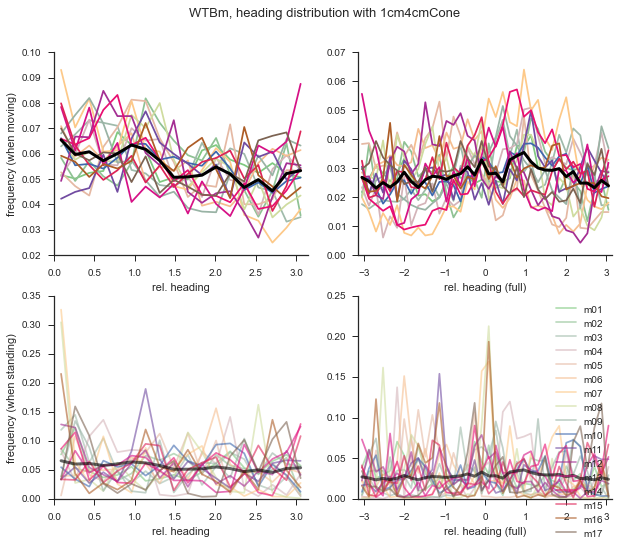

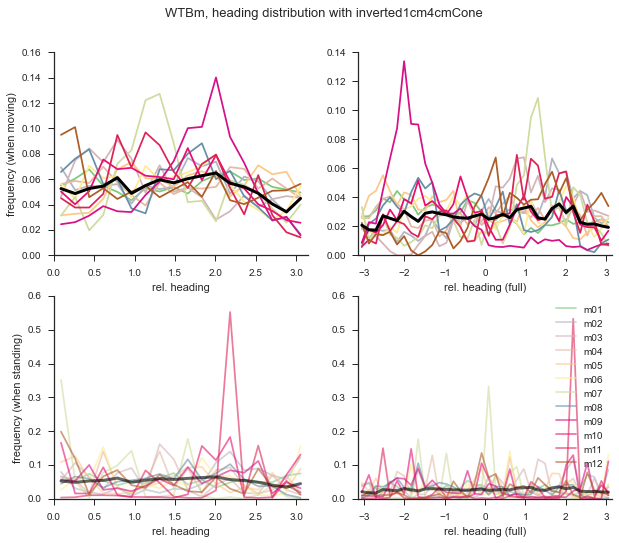

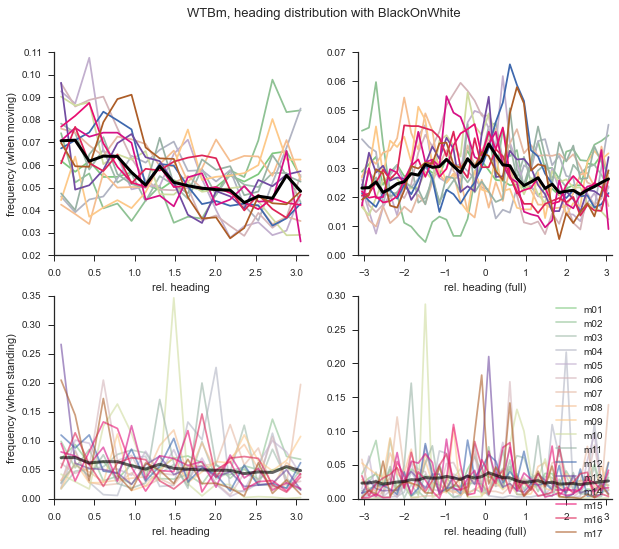

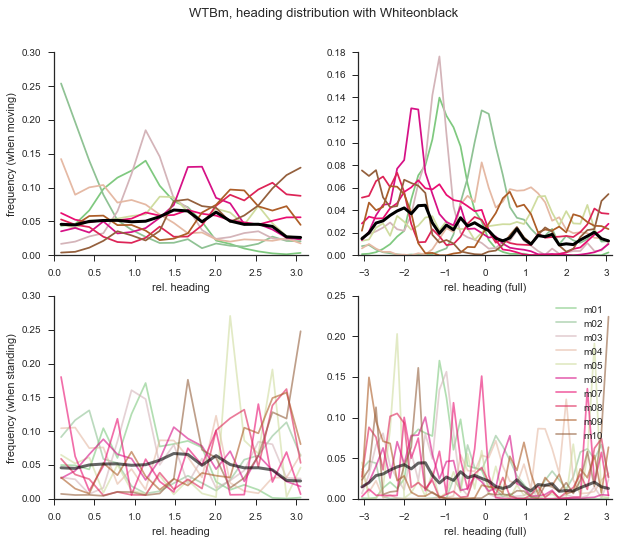

In [42]:
for scene in range(4):
    headingfig = plt.figure(figsize=(10,8))

    scenename = sceneNames[scene]
    print(scenename+'\n')
    densityFlag = True
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig = plotHeadingComparison(scenename,titleString,densityFlag)

    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingDistribution_'+scenename+'_n'+str(numFlies)+'.pdf', format = 'pdf')

1cm4cmCone
fly 3 not moving
6.05833333333
fly 4 not moving
11.875
fly 9 not moving
8.29166666667
fly 10 not moving
13.2833333333
fly 11 not moving
18.9666666667
fly 14 not moving
14.675
fly 21 not moving
11.6083333333
fly 22 not moving
18.175
fly 24 not moving
18.3
inverted1cm4cmCone
fly 1 not moving
17.3166666667
fly 2 not moving
19.825
fly 4 not moving
1.675
fly 7 not moving
11.1333333333
fly 9 not moving
0.0
fly 11 not moving
2.18333333333
fly 13 not moving
5.325
fly 15 not moving
0.15
fly 16 not moving
9.65
fly 17 not moving
4.10833333333
fly 21 not moving
14.4666666667
fly 22 not moving
15.8083333333
fly 24 not moving
0.283333333333
fly 25 not moving
1.475
BlackOnWhite
fly 9 not moving
1.35
fly 10 not moving
15.9
fly 11 not moving
4.71666666667
fly 14 not moving
13.575
fly 17 not moving
19.3333333333
fly 21 not moving
7.54166666667
fly 22 not moving
19.2583333333
fly 24 not moving
0.15
fly 25 not moving
6.75
Whiteonblack
fly 2 not moving
1.675
fly 3 not moving
10.2166666667
fly 4 

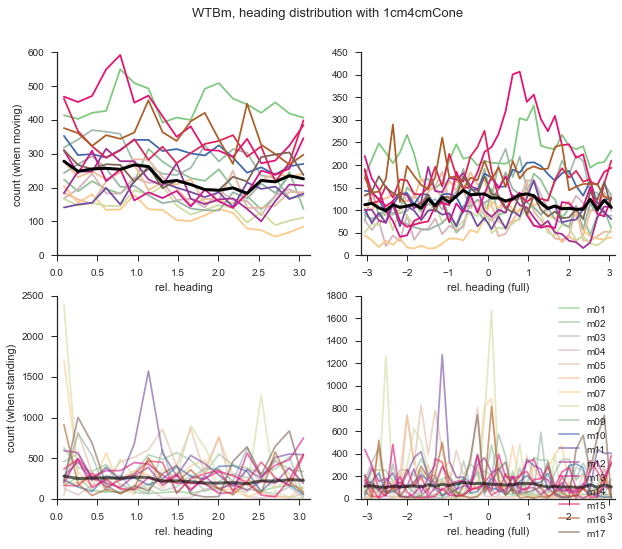

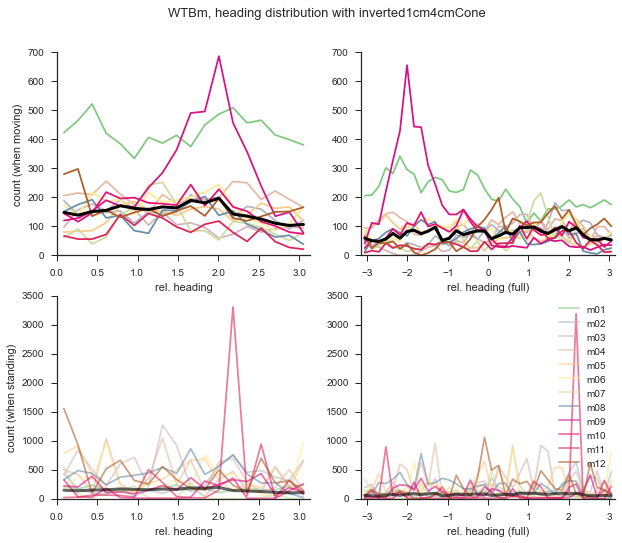

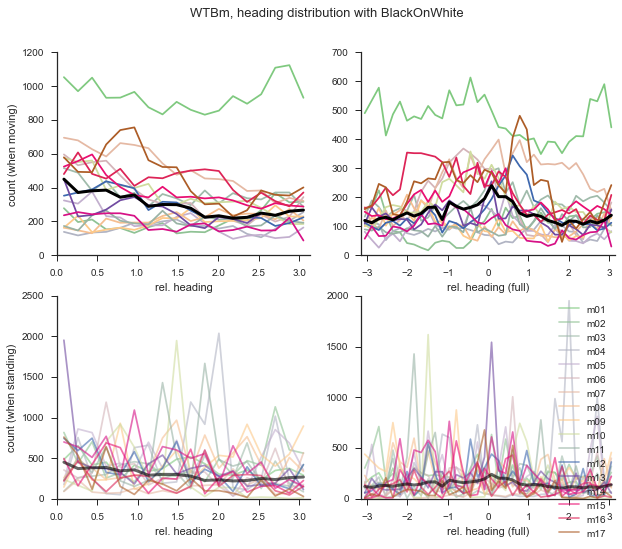

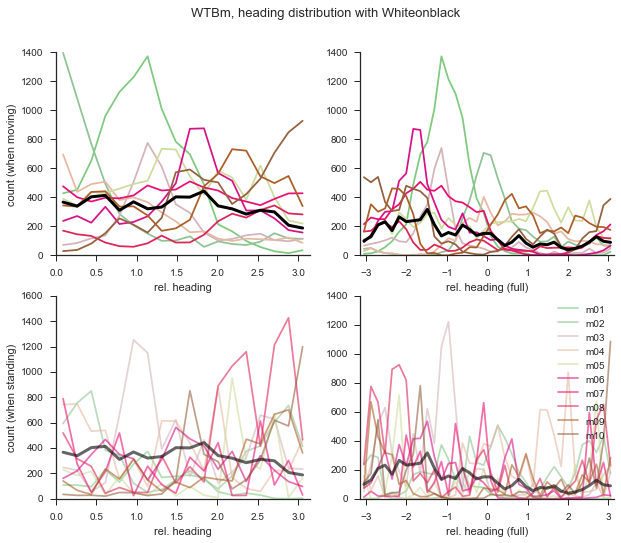

In [43]:
for scene in range(4):
    headingfig = plt.figure(figsize=(10,8))

    scenename = sceneNames[scene]
    print(scenename)
    
    densityFlag = False
    titleString = genotypeSex+', heading distribution with '+ scenename

    headingfig = plotHeadingComparison(scenename,titleString,densityFlag)

    headingfig.savefig(analysisDir + sep + 'heading' + sep + genotypeSex + '_headingCounts_'+scenename+'_n'+str(numFlies)+'.pdf', format = 'pdf')